# Bayesian Hierarchical Modeling

#### Collaborators and Student IDs
Alan Jian 3033730509

Shreya Chowdhury 3033623454

Matilda Ju 3033728143

Yannie Li 3034042574

In [169]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm

In [170]:
with pm.Model() as model:
    dummy = pm.Beta('dummy', alpha=1, beta=1)
    pm.sample(1)

/var/folders/r2/k7ydhtv97nvfmfl71y382zy40000gn/T/ipykernel_9941/1311453619.py:3: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  pm.sample(1)
Only 1 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [dummy]


Sampling 4 chains for 1_000 tune and 1 draw iterations (4_000 + 4 draws total) took 16 seconds.
/Users/alanjian/opt/anaconda3/envs/pymc3_env/lib/python3.9/site-packages/arviz/data/base.py:216: UserWarning: More chains (4) than draws (1). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
/Users/alanjian/opt/anaconda3/envs/pymc3_env/lib/python3.9/site-packages/pymc3/sampling.py:643: UserWarning: The number of samples is too small to check convergence reliably.
  warnings.warn("The number of samples is too small to check convergence reliably.")


# Data Cleaning

Here, we take a bunch of steps to clean up our data and make it suitable for future work. Here are a series of steps that we took:

## Importing Data
We started by importing the data.

In our study we are interested in the following highly polarized issues. To find these, we highlighted differences in the republican and democratic platforms (links below):

https://democrats.org/where-we-stand/party-platform/

https://prod-cdn-static.gop.com/media/documents/DRAFT_12_FINAL%5B1%5D-ben_1468872234.pdf

https://www2.deloitte.com/us/en/pages/public-sector/articles/top-national-issues.html

**Abortion** (ABANY): Please tell me whether or not you think it should be possible for a pregnant woman to obtain a legal abortion if the woman wants it for any reason?

**Gun Regulation** (GUNLAW): Would you favor or oppose a law which would require a person to obtain a police permit before he or she could buy a gun?

**Homosexuality** (HOMOSEX): What about sexual relations between two adults of the same sex--do you think it is always wrong, almost always wrong, wrong only sometimes, or not wrong at all?

**Existence of Racial Discrimination** (RACDIF1): On the average (Negroes/Blacks/African-Americans) have worse jobs, income, and housing than white people.
Do you think these differences are mainly due to discrimination?

**Investment in Environmental Protection** (NATENVIR): We are faced with many problems in this country, none of which can be solved easily or inexpensively. I'm going to name some of these problems, and for each one I'd like you to name some of these problems, and for each one I'd like you to tell me whether you think we're spending too much money on it, too little money, or about the right amount. Are we spending too much, too little, or about the right amount on improving and protecting the environment?

**Investment in National Defense** (NATARMS): We are faced with many problems in this country, none of which can be solved easily or inexpensively. I'm going to name some of these problems, and for each one I'd like you to tell me whether you think we're spending too much money on it, too little money, or about the right amount. Are we spending too much, too little, or about the right amount on national defense?

**Investment in Welfare** (NATFARE): We are faced with many problems in this country, none of which can be solved easily or inexpensively. I'm going to name some of these problems, and for each one I'd like you to name some of these problems, and for each one I'd like you to tell me whether you think we're spending too much money on it, too little money, or about the right amount. Are we spending too much, too little, or about the right amount on Welfare?

**Investment in Social Security** (NATSOC): We are faced with many problems in this country, none of which can be solved easily or inexpensively. I'm going to name some of these problems, and for each one I'd like you to name some of these problems, and for each one I'd like you to tell me whether you think we're spending too much money on it, too little money, or about the right amount. Are we spending too much, too little, or about the right amount on Social Security

In [522]:
labels = ['YEAR', 'POLVIEWS', 'ABANY', 'GUNLAW', 'HOMOSEX', 'RACDIF1', 'NATENVIR', 'NATARMS', 'NATFARE', 'NATSOC']

In [523]:
origlocation = "./GSS/GSS7218_R3"
alanLoc = "~/Downloads/GSS_spss/GSS7218_R3.sav"

pol = pd.read_spss(alanLoc, usecols=labels, 
                     convert_categoricals=True)

## Initial Transformations

Additionally, we make some further modifications, chopping off any data prior to 2000s (because we're interested in the period between 2000-2018).

In [524]:
pol = pol[pol['YEAR'] >= 2000]
pol

,YEAR,POLVIEWS,NATENVIR,NATARMS,NATFARE,NATSOC,GUNLAW,ABANY,HOMOSEX,RACDIF1
38116,2000.0,SLGHTLY CONSERVATIVE,TOO LITTLE,TOO MUCH,TOO MUCH,TOO LITTLE,OPPOSE,NO,NOT WRONG AT ALL,NO
38117,2000.0,CONSERVATIVE,NaN,NaN,NaN,TOO LITTLE,FAVOR,NO,NaN,NaN
38118,2000.0,CONSERVATIVE,TOO LITTLE,TOO LITTLE,ABOUT RIGHT,ABOUT RIGHT,NaN,NaN,NaN,NO
38119,2000.0,SLGHTLY CONSERVATIVE,TOO LITTLE,TOO MUCH,TOO MUCH,TOO LITTLE,NaN,NaN,NaN,NO
38120,2000.0,SLIGHTLY LIBERAL,NaN,NaN,NaN,ABOUT RIGHT,NaN,NaN,NaN,NO
...,...,...,...,...,...,...,...,...,...,...
64809,2018.0,MODERATE,TOO LITTLE,ABOUT RIGHT,TOO LITTLE,ABOUT RIGHT,OPPOSE,YES,NOT WRONG AT ALL,YES
64810,2018.0,SLGHTLY CONSERVATIVE,ABOUT RIGHT,ABOUT RIGHT,ABOUT RIGHT,TOO LITTLE,OPPOSE,NO,NaN,NO
64811,2018.0,MODERATE,NaN,NaN,NaN,ABOUT RIGHT,FAVOR,NO,NOT WRONG AT ALL,NaN
64812,2018.0,CONSERVATIVE,ABOUT RIGHT,TOO LITTLE,TOO MUCH,TOO LITTLE,NaN,NaN,NaN,NO


Since we're most interested in political viewpoint, and it was asked of everyone, we will remove individuals who did not respond, since updates that correspond with those data are not informative.

In [525]:
pol = pol[~pol['POLVIEWS'].isna()]
pol

,YEAR,POLVIEWS,NATENVIR,NATARMS,NATFARE,NATSOC,GUNLAW,ABANY,HOMOSEX,RACDIF1
38116,2000.0,SLGHTLY CONSERVATIVE,TOO LITTLE,TOO MUCH,TOO MUCH,TOO LITTLE,OPPOSE,NO,NOT WRONG AT ALL,NO
38117,2000.0,CONSERVATIVE,NaN,NaN,NaN,TOO LITTLE,FAVOR,NO,NaN,NaN
38118,2000.0,CONSERVATIVE,TOO LITTLE,TOO LITTLE,ABOUT RIGHT,ABOUT RIGHT,NaN,NaN,NaN,NO
38119,2000.0,SLGHTLY CONSERVATIVE,TOO LITTLE,TOO MUCH,TOO MUCH,TOO LITTLE,NaN,NaN,NaN,NO
38120,2000.0,SLIGHTLY LIBERAL,NaN,NaN,NaN,ABOUT RIGHT,NaN,NaN,NaN,NO
...,...,...,...,...,...,...,...,...,...,...
64808,2018.0,MODERATE,ABOUT RIGHT,ABOUT RIGHT,TOO MUCH,TOO LITTLE,FAVOR,NO,SOMETIMES WRONG,NaN
64809,2018.0,MODERATE,TOO LITTLE,ABOUT RIGHT,TOO LITTLE,ABOUT RIGHT,OPPOSE,YES,NOT WRONG AT ALL,YES
64810,2018.0,SLGHTLY CONSERVATIVE,ABOUT RIGHT,ABOUT RIGHT,ABOUT RIGHT,TOO LITTLE,OPPOSE,NO,NaN,NO
64811,2018.0,MODERATE,NaN,NaN,NaN,ABOUT RIGHT,FAVOR,NO,NOT WRONG AT ALL,NaN


In [526]:
# sanity check to make sure we're including all the right years.
sorted(causal['YEAR'].value_counts().index)

[2000.0,
 2002.0,
 2004.0,
 2006.0,
 2008.0,
 2010.0,
 2012.0,
 2014.0,
 2016.0,
 2018.0]

When comparing the data from the GSS data explorer and our extracted data, it looks like NaN values are comprised of three different types of users:
1. **Declined to Respond**: They did not respond to the prompt
2. **Don't Know**: They did not know enough about the subject to respond
3. **Not Applicable:** They were not asked the prompt

In [527]:
pol[['POLVIEWS']].isna().groupby('POLVIEWS').size()

POLVIEWS
False    22849
dtype: int64

An overwhelming majority of these NaNs are comprised of those who were never asked the question (>95%), so we can safely assume that they are missing completely at random (MCAR).

We can also see that, with a total size of 27000 respondents, a majority of these questions were only asked to roughly half of the individuals in the study, with the exception of self-reported political leaning, and opinion of investment in social security.

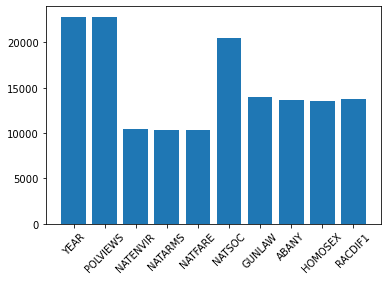

In [528]:
num_responses = np.sum(~pol.isna(), axis=0)
plt.bar(num_responses.index, num_responses)
plt.xticks(rotation=45);

# Binarizing Variables
In order for our study to match the design of our bayesian hierarchical model, we will have to binarize all of the questions that feature multiple values.

As a result, these variables and their interpretation will be changed in the following way:
1. **Homosexuality** (HOMOSEX): What about sexual relations between two adults of the same sex--do you think it is wrong at all?
2. **Gender Discrimination in the Workplace** (DISCAFF): Do you think that it's likely these days that a woman won't get a job or promotion while an equally or less qualified man gets one instead?
4. **Investment in Environmental Protection** (NATENVIR): Do we need to spend more on protecting the environment?
5. **Investment in National Defense** (NATARMS): Do we need to spend more on national defense?
6. **Investment in Welfare** (NATFARE): Do we need to spend more on welfare?
7. **Investment in Social Security** (NATSOC): Do we need to spend more on social security?

Additionally, since PyMC3 works with numerical values, we'll also have to binarize:
1. **Abortion** (ABANY)
2. **Existence of Racial Discrimination** (RACDIF1)
3. **Gun Regulation** (GUNLAW)

In [529]:
binarized = pol.copy()

### Homosexuality

In [530]:
pol['HOMOSEX'].value_counts()

ALWAYS WRONG        6354
NOT WRONG AT ALL    5673
SOMETIMES WRONG      949
ALMST ALWAYS WRG     546
OTHER                  0
Name: HOMOSEX, dtype: int64

In [531]:
pd.get_dummies(pol[['HOMOSEX']]).columns

Index(['HOMOSEX_ALMST ALWAYS WRG', 'HOMOSEX_ALWAYS WRONG',
       'HOMOSEX_NOT WRONG AT ALL', 'HOMOSEX_OTHER', 'HOMOSEX_SOMETIMES WRONG'],
      dtype='object')

In [532]:
# Find individuals who think homosexuality is wrong
homosex = pd.get_dummies(pol[['HOMOSEX']])[['HOMOSEX_ALMST ALWAYS WRG', 
                                           'HOMOSEX_ALWAYS WRONG', 
                                           'HOMOSEX_SOMETIMES WRONG']]
homo_bool = np.sum(homosex, axis=1)

#Re-identify those who did not answer the question
homo_bool.iloc[pol['HOMOSEX'].isna().to_list()] = np.nan

binarized['HOMOSEX'] = homo_bool
homo_bool

38116    0.0
38117    NaN
38118    NaN
38119    NaN
38120    NaN
        ... 
64808    1.0
64809    0.0
64810    NaN
64811    0.0
64812    NaN
Length: 22849, dtype: float64

### Gender Discrimination in the Workplace

In [499]:
"""# Find individuals who think gender discrimination is likely to occur even today
pol['DISCAFFW'].value_counts()"""

SOMEWHAT LIKELY      3298
VERY LIKELY          1655
SOMEWHAT UNLIKELY    1292
VERY UNLIKELY         586
Name: DISCAFFW, dtype: int64

In [533]:
"""discaffw = pd.get_dummies(pol[['DISCAFFW']])[['DISCAFFW_SOMEWHAT LIKELY',
                                            'DISCAFFW_VERY LIKELY']]

discaffw_bool = np.sum(discaffw, axis=1)

#Re-identify those who did not answer the question
discaffw_bool.iloc[pol['DISCAFFW'].isna().to_list()] = np.nan

binarized['DISCAFFW'] = discaffw_bool
discaffw_bool"""

"discaffw = pd.get_dummies(pol[['DISCAFFW']])[['DISCAFFW_SOMEWHAT LIKELY',\n                                            'DISCAFFW_VERY LIKELY']]\n\ndiscaffw_bool = np.sum(discaffw, axis=1)\n\n#Re-identify those who did not answer the question\ndiscaffw_bool.iloc[pol['DISCAFFW'].isna().to_list()] = np.nan\n\nbinarized['DISCAFFW'] = discaffw_bool\ndiscaffw_bool"

### Investment in Environmental Protection

In [534]:
pol['NATENVIR'].value_counts()

TOO LITTLE     6580
ABOUT RIGHT    2975
TOO MUCH        885
Name: NATENVIR, dtype: int64

In [535]:
# Find individuals who think we aren't spending enough on climate change and preserving environment
natenvir_bool = pd.get_dummies(pol[['NATENVIR']])[['NATENVIR_TOO LITTLE']]

#Re-identify those who did not answer the question
natenvir_bool.iloc[pol['NATENVIR'].isna().to_list()] = np.nan

binarized['NATENVIR'] = natenvir_bool
natenvir_bool

,NATENVIR_TOO LITTLE
38116,1.0
38117,NaN
38118,1.0
38119,1.0
38120,NaN
...,...
64808,0.0
64809,1.0
64810,0.0
64811,NaN


### Investment in National Defense

In [536]:
pol['NATARMS'].value_counts()

ABOUT RIGHT    3988
TOO MUCH       3278
TOO LITTLE     3107
Name: NATARMS, dtype: int64

In [537]:
# Find individuals who think we aren't spending enough on national defense and army
natarms_bool = pd.get_dummies(pol[['NATARMS']])[['NATARMS_TOO LITTLE']]

# Re-identify those who did not answer the question
natarms_bool.iloc[pol['NATARMS'].isna().to_list()] = np.nan

binarized['NATARMS'] = natarms_bool
natarms_bool

,NATARMS_TOO LITTLE
38116,0.0
38117,NaN
38118,1.0
38119,0.0
38120,NaN
...,...
64808,0.0
64809,0.0
64810,0.0
64811,NaN


### Investment in Welfare

In [538]:
natfare_bool = pd.get_dummies(pol[['NATFARE']])[['NATFARE_TOO LITTLE']]

# Re-identify those who did not answer the question
natfare_bool.iloc[pol['NATFARE'].isna().to_list()] = np.nan

binarized['NATFARE'] = natfare_bool
natfare_bool

,NATFARE_TOO LITTLE
38116,0.0
38117,NaN
38118,0.0
38119,0.0
38120,NaN
...,...
64808,0.0
64809,1.0
64810,0.0
64811,NaN


### Investment in Social Security

In [539]:
natsoc_bool = pd.get_dummies(pol[['NATSOC']])[['NATSOC_TOO LITTLE']]

# Re-identify those who did not answer the question
natsoc_bool.iloc[pol['NATSOC'].isna().to_list()] = np.nan

binarized['NATSOC'] = natsoc_bool
natsoc_bool

,NATSOC_TOO LITTLE
38116,1.0
38117,1.0
38118,0.0
38119,1.0
38120,0.0
...,...
64808,1.0
64809,0.0
64810,1.0
64811,0.0


### Opinion on Gun Regulation

In [540]:
pol[['GUNLAW']].value_counts()

GUNLAW
FAVOR     10679
OPPOSE     3339
dtype: int64

In [541]:
gunlaw_bool = pd.get_dummies(pol[['GUNLAW']])[['GUNLAW_FAVOR']]

#Re-identify those who did not answer the question
gunlaw_bool.iloc[pol['GUNLAW'].isna().to_list()] = np.nan

binarized['GUNLAW'] = gunlaw_bool
gunlaw_bool

,GUNLAW_FAVOR
38116,0.0
38117,1.0
38118,NaN
38119,NaN
38120,NaN
...,...
64808,1.0
64809,0.0
64810,0.0
64811,1.0


### Opinion on Abortion

In [542]:
pol[['ABANY']].value_counts()

ABANY
NO       7640
YES      6052
dtype: int64

In [543]:
abany_bool = pd.get_dummies(pol[['ABANY']])[['ABANY_YES']]

#Re-identify those who did not answer the question
abany_bool.iloc[pol['ABANY'].isna().to_list()] = np.nan

binarized['ABANY'] = abany_bool
abany_bool

,ABANY_YES
38116,0.0
38117,0.0
38118,NaN
38119,NaN
38120,NaN
...,...
64808,0.0
64809,1.0
64810,0.0
64811,0.0


### Opinion on Racial Discrimination

In [544]:
pol[['ABANY']].value_counts()

ABANY
NO       7640
YES      6052
dtype: int64

In [545]:
racdif1_bool = pd.get_dummies(pol[['RACDIF1']])[['RACDIF1_YES']]

#Re-identify those who did not answer the question
racdif1_bool.iloc[pol['RACDIF1'].isna().to_list()] = np.nan

binarized['RACDIF1'] = racdif1_bool
racdif1_bool

,RACDIF1_YES
38116,0.0
38117,NaN
38118,0.0
38119,0.0
38120,0.0
...,...
64808,NaN
64809,1.0
64810,0.0
64811,NaN


# Centering and Reorganizing POLVIEWS

As per Ramesh's suggestion, we're centering `POLVIEWS` at 0, so that the sign of the variable is informative in whether or not someone is conservative or liberal.

In [546]:
pol[['POLVIEWS']].value_counts()

POLVIEWS            
MODERATE                8831
CONSERVATIVE            3601
SLGHTLY CONSERVATIVE    3231
LIBERAL                 2770
SLIGHTLY LIBERAL        2604
EXTREMELY LIBERAL        917
EXTRMLY CONSERVATIVE     895
dtype: int64

In [547]:
neg_three = pol[['POLVIEWS']] == 'EXTREMELY LIBERAL'
neg_two = pol[['POLVIEWS']] == 'LIBERAL'
neg_one = pol[['POLVIEWS']] == 'SLIGHTLY LIBERAL'
zero = pol[['POLVIEWS']] == 'MODERATE'
one = pol[['POLVIEWS']] == 'SLGHTLY CONSERVATIVE'
two = pol[['POLVIEWS']] == 'CONSERVATIVE'
three = pol[['POLVIEWS']] == 'EXTRMLY CONSERVATIVE'

In [548]:
polviews = -3 * neg_three + -2 * neg_two + -1 * neg_one + 0 * zero + 1 * one + 2 * two + 3 * three
binarized['POLVIEWS'] = polviews
polviews

,POLVIEWS
38116,1
38117,2
38118,2
38119,1
38120,-1
...,...
64808,0
64809,0
64810,1
64811,0


# Cleaned Data Ready for Use!

In [549]:
clean_data = binarized.copy()
clean_data.head()

,YEAR,POLVIEWS,NATENVIR,NATARMS,NATFARE,NATSOC,GUNLAW,ABANY,HOMOSEX,RACDIF1
38116,2000.0,1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
38117,2000.0,2,NaN,NaN,NaN,1.0,1.0,0.0,NaN,NaN
38118,2000.0,2,1.0,1.0,0.0,0.0,NaN,NaN,NaN,0.0
38119,2000.0,1,1.0,0.0,0.0,1.0,NaN,NaN,NaN,0.0
38120,2000.0,-1,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0


# Notes on Value Imputation

Like I said before, our data is MCAR, so it stands that we could just use automatic imputation as implemented by PyMC3. In order to do this, we literally do nothing; PyMC3 will automatically do the imputation once it sees NaN values (source: https://discourse.pymc.io/t/missing-values-in-a-model/2157/9).

Logically, this imputation will not affect our update to the prior, since it is treated as an unseen random variable with a prior that can be updated just like any other random variable.

# Yeet
Let's do this thing!

In [550]:
test = clean_data.dropna()
test

,YEAR,POLVIEWS,NATENVIR,NATARMS,NATFARE,NATSOC,GUNLAW,ABANY,HOMOSEX,RACDIF1
38116,2000.0,1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
38122,2000.0,0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
38137,2000.0,0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0
38138,2000.0,-1,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
38139,2000.0,2,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...
64786,2018.0,-3,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0
64791,2018.0,-2,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0
64799,2018.0,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
64805,2018.0,0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0


In [551]:
#questions = clean_data.columns[2:]
questions = test.columns[2:]
questions

Index(['NATENVIR', 'NATARMS', 'NATFARE', 'NATSOC', 'GUNLAW', 'ABANY',
       'HOMOSEX', 'RACDIF1'],
      dtype='object')

In [552]:
import theano.tensor as tt

In [631]:
with pm.Model() as model:
    
    eps = pm.Normal('eps', 0, 0.025)
    beta_vector = pm.Flat('beta', shape=(len(questions), 1))
    noisy = test['POLVIEWS'].to_numpy() + eps
    p = pm.math.sigmoid(tt.outer(noisy, beta_vector))
    pm.Bernoulli('ys', p=p, observed=test[questions])
    
    trace = pm.sample(500, tune=2000)

/var/folders/r2/k7ydhtv97nvfmfl71y382zy40000gn/T/ipykernel_9941/2085958981.py:9: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(500, tune=2000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, eps]


Sampling 4 chains for 2_000 tune and 500 draw iterations (8_000 + 2_000 draws total) took 97 seconds.


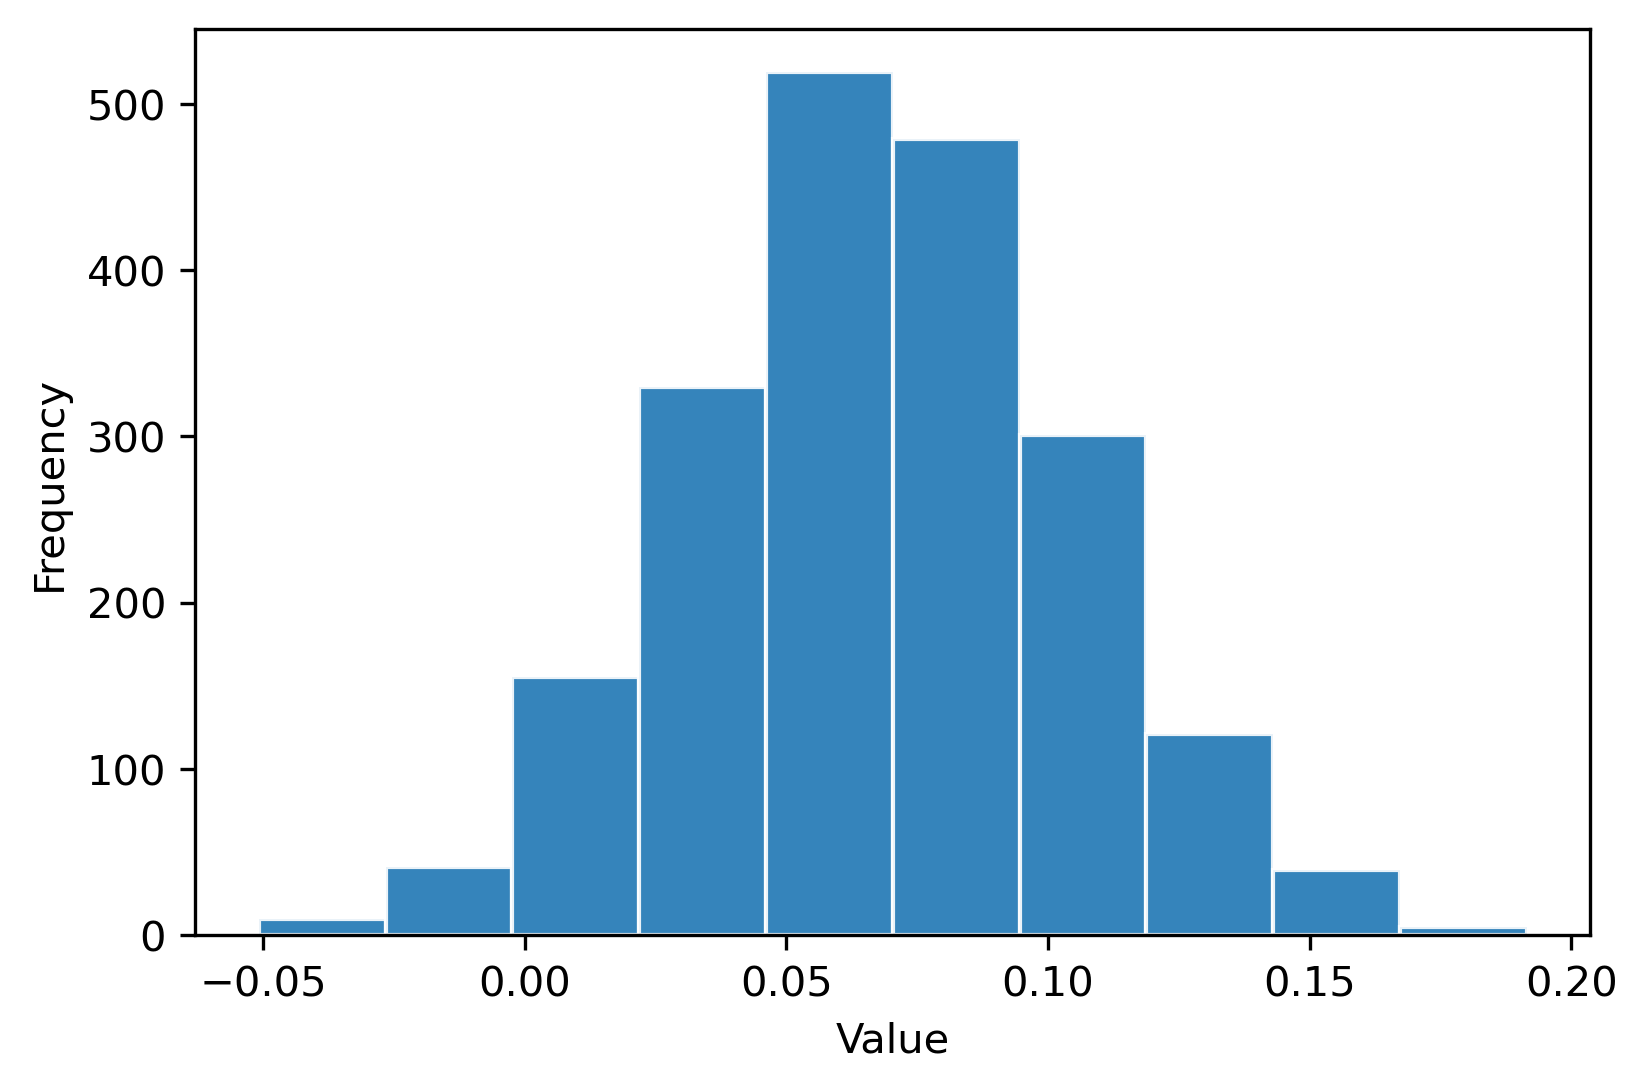

In [658]:
plt.figure(dpi=300)
plt.hist(trace['eps'], ec='w', alpha=0.9)
plt.xlabel("Value")
plt.ylabel("Frequency");
plt.savefig("/Users/alanjian/Desktop/Data 102/Posterior of Eps")

In [648]:
# Concentration inequality
np.mean(trace['eps'] >= 0)

0.97

In [788]:
np.mean(trace['eps'])

0.06813629620390414

(array([  5.,  24.,  98., 246., 424., 533., 381., 208.,  66.,  15.]),
 array([-0.39674304, -0.37752905, -0.35831507, -0.33910108, -0.3198871 ,
        -0.30067311, -0.28145913, -0.26224514, -0.24303116, -0.22381717,
        -0.20460319]),
 <BarContainer object of 10 artists>)

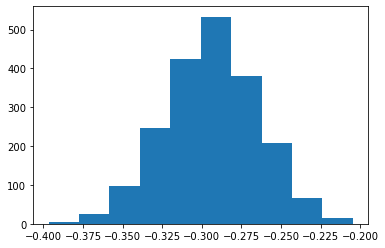

In [636]:
#NATENVIR
plt.figure(dpi=300)
plt.hist(trace['beta'][:, 0], ec='w', alpha=0.9)
plt.xlabel("Value")
plt.ylabel("Frequency");
plt.savefig("/Users/alanjian/Desktop/Data 102/Posterior of Eps")

(array([  5.,  41., 136., 320., 457., 481., 354., 145.,  50.,  11.]),
 array([0.10736056, 0.12742431, 0.14748806, 0.16755181, 0.18761556,
        0.20767931, 0.22774306, 0.24780681, 0.26787056, 0.28793431,
        0.30799806]),
 <BarContainer object of 10 artists>)

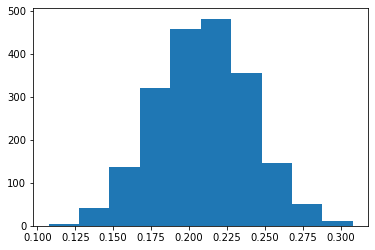

In [637]:
#NATARMS
plt.figure(dpi=300)
plt.hist(trace['beta'][:, 1], ec='w', alpha=0.9)

(array([ 15.,  72., 225., 456., 577., 419., 176.,  44.,  12.,   4.]),
 array([-0.43376586, -0.40957713, -0.38538841, -0.36119968, -0.33701095,
        -0.31282222, -0.28863349, -0.26444477, -0.24025604, -0.21606731,
        -0.19187858]),
 <BarContainer object of 10 artists>)

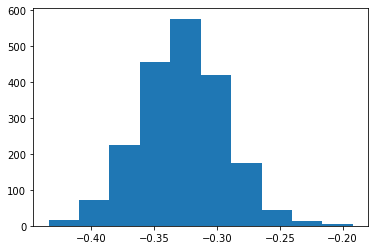

In [638]:
#NATFARE
plt.figure(dpi=300)
plt.hist(trace['beta'][:, 2], ec='w', alpha=0.9)

(array([  9.,  50., 195., 374., 532., 488., 256.,  67.,  28.,   1.]),
 array([-0.14951508, -0.13054542, -0.11157575, -0.09260608, -0.07363642,
        -0.05466675, -0.03569708, -0.01672741,  0.00224225,  0.02121192,
         0.04018159]),
 <BarContainer object of 10 artists>)

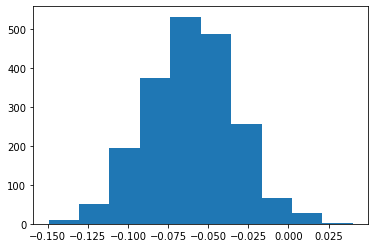

In [639]:
#NATSOC
plt.figure(dpi=300)
plt.hist(trace['beta'][:, 3], ec='w', alpha=0.9)

(array([ 14.,  63., 143., 330., 482., 443., 322., 148.,  48.,   7.]),
 array([-0.21006821, -0.19063603, -0.17120386, -0.15177168, -0.13233951,
        -0.11290733, -0.09347516, -0.07404298, -0.05461081, -0.03517863,
        -0.01574646]),
 <BarContainer object of 10 artists>)

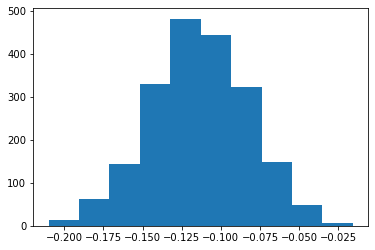

In [640]:
#GUNLAW
plt.figure(dpi=300)
plt.hist(trace['beta'][:, 4], ec='w', alpha=0.9)

(array([  3.,  22., 113., 277., 416., 517., 404., 180.,  61.,   7.]),
 array([-0.52919035, -0.51031159, -0.49143283, -0.47255407, -0.45367531,
        -0.43479655, -0.41591779, -0.39703903, -0.37816027, -0.35928151,
        -0.34040275]),
 <BarContainer object of 10 artists>)

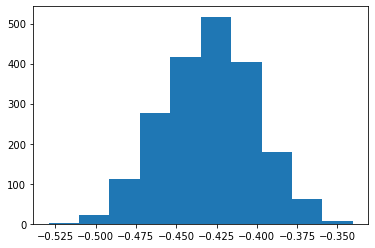

In [641]:
#ABANY
plt.figure(dpi=300)
plt.hist(trace['beta'][:, 5], ec='w', alpha=0.9)

(array([  7.,  56., 201., 489., 584., 427., 177.,  53.,   5.,   1.]),
 array([0.33579566, 0.35796155, 0.38012744, 0.40229333, 0.42445921,
        0.4466251 , 0.46879099, 0.49095688, 0.51312277, 0.53528865,
        0.55745454]),
 <BarContainer object of 10 artists>)

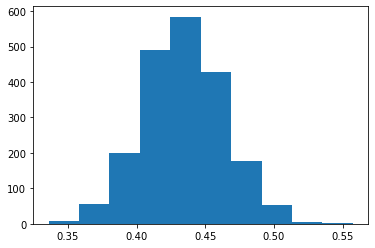

In [642]:
#HOMOSEX (I defined it in the inverse; Do you think Homosexual relations are wrong?)
plt.figure(dpi=300)
plt.hist(trace['beta'][:, 6], ec='w', alpha=0.9)

(array([  9.,  51., 171., 406., 543., 459., 251.,  86.,  21.,   3.]),
 array([-0.35909741, -0.33899009, -0.31888278, -0.29877547, -0.27866816,
        -0.25856084, -0.23845353, -0.21834622, -0.1982389 , -0.17813159,
        -0.15802428]),
 <BarContainer object of 10 artists>)

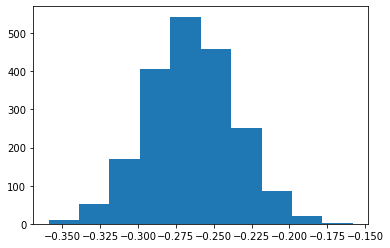

In [643]:
#RACDIF1
plt.figure(dpi=300)
plt.hist(trace['beta'][:, 7], ec='w', alpha=0.9)

In [644]:
"""#DISCAFF
plt.hist(trace['beta'][:, 8])"""

"#DISCAFF\nplt.hist(trace['beta'][:, 8])"

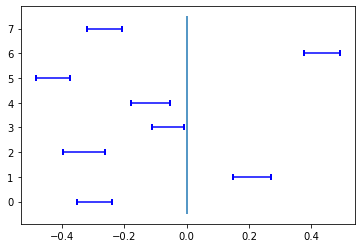

In [671]:
plt.vlines(0, -0.5, 7.5)
for i in np.arange(8):
    posterior = trace['beta'][:, i]
    pts = [np.percentile(posterior, 2.5), np.percentile(posterior, 97.5)]
    plt.hlines(i, pts[0], pts[1], color='b')
    plt.scatter(pts, [i, i], color='b', lw=2, marker='|')

In [781]:
[trace['beta'][:, i] for i in np.arange(8)]
labels = ['Environment', "Nat'l Security", 'Welfare', 'Social Security', 'Gun Regulation', 'Abortion', 'Homosexuality', 'Race Discrimination']
idea = pd.DataFrame(columns=['x', 'label'])
i = 0
while i < len(labels):
    df = pd.DataFrame(trace['beta'][:, i].flatten()).rename({0:'x'}, axis=1)
    df['label'] = labels[i]
    idea = idea.append(df)
    i += 1 
idea['hue'] = idea['x'] < 0
idea = idea.sort_values('x', ascending=False)
idea

,x,label,hue
286,0.557455,Homosexuality,False
432,0.521324,Homosexuality,False
580,0.520051,Homosexuality,False
771,0.519373,Homosexuality,False
485,0.516107,Homosexuality,False
...,...,...,...
451,-0.506627,Abortion,True
1630,-0.509734,Abortion,True
1612,-0.510869,Abortion,True
151,-0.514576,Abortion,True


<Figure size 1800x1200 with 0 Axes>

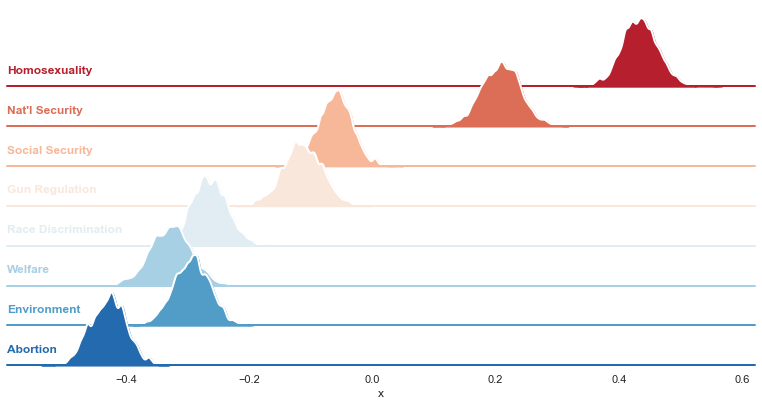

In [787]:
import seaborn as sns
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

plt.figure(dpi=300)
# Initialize the FacetGrid object
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(idea, row="label", hue="label", aspect=15, height=.75, palette='RdBu')

# Draw the densities in a few steps
g.map(sns.kdeplot, 'x',
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, 'x', clip_on=False, color="w", lw=2, bw_adjust=.5)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, 'x')

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.5)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True);
#plt.savefig("/Users/alanjian/Desktop/Data 102/Beta Posteriors")